### Scenario

- Working as an analyst with internet service provider and provided with this historical data about company's customers and their churn trends. The task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
churnData = pd.read_csv('Customer_Churn.csv')

In [3]:
churnData.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churnData.shape

(7043, 21)

In [5]:
churnData.info() # the data doesn't contain null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
for col in churnData.select_dtypes('object'):
    print(col, churnData[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn ['No' 'Yes']


In [7]:
# clean some Features
churnData['TotalCharges'] = pd.to_numeric(churnData['TotalCharges'], errors = 'coerce') # (If 'coerce' then invalid parsing will be set as NaN. )

In [8]:
churnData['TotalCharges'].dtype

dtype('float64')

In [9]:
churnData['TotalCharges'] .isna().sum()

11

- To the given data'TotalCharges' has no null values, though after converting it into a numerical. The dataframe has 11 rows of nan values. 

In [10]:
churnData.query('TotalCharges.isna()')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


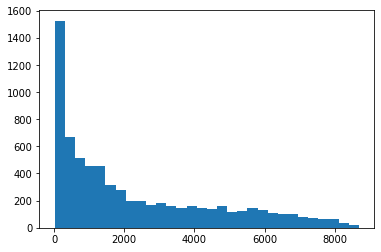

In [11]:
plt.hist(churnData['TotalCharges'], bins = 30);

- After seeing distribution plot, decided to replace the null values with 'ZERO'

In [13]:
churnData['TotalCharges']=churnData['TotalCharges'].fillna(0)

In [14]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Prepare Data for the model

In [17]:
X = churnData[['tenure','SeniorCitizen', 'MonthlyCharges','TotalCharges']]
y= churnData['Churn']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [24]:
# Class imbalance on Target 'Churn'
print(y.value_counts())
print(y.value_counts()/y.shape[0])

No     5174
Yes    1869
Name: Churn, dtype: int64
No     0.73463
Yes    0.26537
Name: Churn, dtype: float64


- we can see clear calss imbalance on Target variable 'Churn'

In [25]:
# fn to create pipelines - note that no encoding for categorials is inclused sicne all features are numericals
def custom_pipeline(scaler, model, sampler=None):
    if sampler:
        return Pipeline([
            ('scaler', scaler),
            ('sampler', sampler),
            ('model', model)
        ])
    else:
        return Pipeline([
            ('scaler', scaler),
            ('model', model)
        ])

In [26]:
def show_confusion_matrix(y_pred, y_test, classes, title):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(colorbar=False)
    disp.ax_.set_title(title)
    plt.show()

# Model 1
- No sampler to address class imbalance on Target

In [30]:
clf_base = custom_pipeline(StandardScaler(), LogisticRegression())
clf_base.fit(X_train, y_train)

y_pred_base = clf_base.predict(X_test)


In [31]:
print('LogisticRegression - No sampler')
print(classification_report(y_test, y_pred_base))

LogisticRegression - No sampler
              precision    recall  f1-score   support

          No       0.82      0.91      0.87      1552
         Yes       0.66      0.45      0.54       561

    accuracy                           0.79      2113
   macro avg       0.74      0.68      0.70      2113
weighted avg       0.78      0.79      0.78      2113



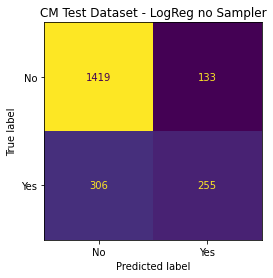

In [33]:
show_confusion_matrix(y_pred_base, y_test, clf_base[1].classes_, 'CM Test Dataset - LogReg no Sampler')

### Model 2 and 3: 
- Use Upsampler to address class imbalance on target - SMOTE and RandomOverSampler

In [34]:
clf_SMOTE = custom_pipeline(StandardScaler(), LogisticRegression(), SMOTE())
clf_SMOTE.fit(X_train, y_train);

LogisticRegression - SMOTE
              precision    recall  f1-score   support

          No       0.89      0.71      0.79      1552
         Yes       0.49      0.75      0.59       561

    accuracy                           0.72      2113
   macro avg       0.69      0.73      0.69      2113
weighted avg       0.78      0.72      0.74      2113



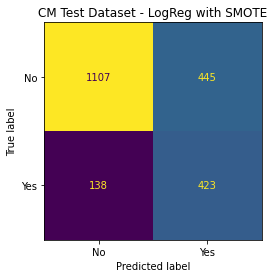

In [35]:
y_pred_smote = clf_SMOTE.predict(X_test)
print('LogisticRegression - SMOTE')
print(classification_report(y_test, y_pred_smote))
show_confusion_matrix(y_pred_smote, y_test, clf_SMOTE[2].classes_, 'CM Test Dataset - LogReg with SMOTE')

In [36]:
clf_ros = custom_pipeline(StandardScaler(), LogisticRegression(), RandomOverSampler())
clf_ros.fit(X_train, y_train);

LogisticRegression - ROS
              precision    recall  f1-score   support

          No       0.89      0.72      0.80      1552
         Yes       0.49      0.74      0.59       561

    accuracy                           0.73      2113
   macro avg       0.69      0.73      0.69      2113
weighted avg       0.78      0.73      0.74      2113



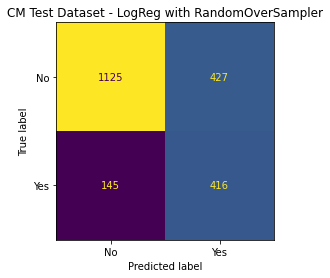

In [37]:
y_pred_ros = clf_ros.predict(X_test)
print('LogisticRegression - ROS')
print(classification_report(y_test, y_pred_ros))
show_confusion_matrix(y_pred_ros, y_test, clf_ros[2].classes_, 'CM Test Dataset - LogReg with RandomOverSampler')

## Model 4: 
- Use Downsampler to address class imbalance on target

In [38]:
clf_rus = custom_pipeline(StandardScaler(), LogisticRegression(), RandomUnderSampler())
clf_rus.fit(X_train, y_train);

LogisticRegression - RUS
              precision    recall  f1-score   support

          No       0.89      0.72      0.79      1552
         Yes       0.49      0.75      0.59       561

    accuracy                           0.73      2113
   macro avg       0.69      0.73      0.69      2113
weighted avg       0.78      0.73      0.74      2113



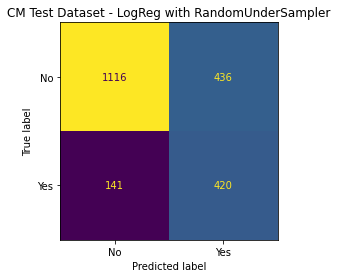

In [39]:
y_pred_rus = clf_rus.predict(X_test)
print('LogisticRegression - RUS')
print(classification_report(y_test, y_pred_rus))
show_confusion_matrix(y_pred_rus, y_test, clf_rus[2].classes_, 'CM Test Dataset - LogReg with RandomUnderSampler')

#### Comparisions

In [47]:
def add_scores_to_overall_results(churnData_results, scores_test, sampler, estimator):
    churnData_results.loc[churnData_results.shape[0]] = [get_class_name(estimator), get_class_name(sampler) if sampler else None,
                                          scores_test.at["accuracy","f1-score"], scores_test.at["Yes","f1-score"],
                                          scores_test.at["Yes","precision"], scores_test.at["Yes","recall"],
                                          scores_test.at["No","f1-score"], scores_test.at["Yes","precision"],
                                          scores_test.at["No","recall"]]
    
def get_class_name(cl):
    return cl.__class__.__name__

In [48]:
model_comparisson = pd.DataFrame([], columns=['model', 'sampler', 'f1_score', 'yes_f1', \
                                          'yes_precision', 'yes_recall', 'no_f1', 'no_precision', 'no_recall'])


In [49]:
# Add the outcomes from all models to an overview table
add_scores_to_overall_results(model_comparisson, 
                              pd.DataFrame(classification_report(y_test, y_pred_base, output_dict=True)).T, 
                              None, 
                              clf_base[1])

add_scores_to_overall_results(model_comparisson, 
                              pd.DataFrame(classification_report(y_test, y_pred_smote, output_dict=True)).T, 
                              clf_SMOTE[1], 
                              clf_SMOTE[2])

add_scores_to_overall_results(model_comparisson, 
                              pd.DataFrame(classification_report(y_test, y_pred_ros, output_dict=True)).T, 
                              clf_ros[1], 
                              clf_ros[2])

add_scores_to_overall_results(model_comparisson, 
                              pd.DataFrame(classification_report(y_test, y_pred_rus, output_dict=True)).T, 
                              clf_rus[1], 
                              clf_rus[2])

In [50]:
# sort by f1 score
model_comparisson.sort_values(by='f1_score', ascending=False)

,model,sampler,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
0,LogisticRegression,None,0.792239,0.537408,0.657216,0.454545,0.866036,0.657216,0.914304
2,LogisticRegression,RandomOverSampler,0.729295,0.592593,0.493476,0.741533,0.797307,0.493476,0.724871
3,LogisticRegression,RandomUnderSampler,0.726929,0.592802,0.490654,0.748663,0.794589,0.490654,0.719072
1,LogisticRegression,SMOTE,0.724089,0.592022,0.487327,0.754011,0.791562,0.487327,0.713273


- The highest f1 score is for the Logistic Regression without any measures against class imabalance, however here we also see the lowest recall for the postive class